In [63]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo
import cartopy.crs as ccrs
import gsw
from eofs.xarray import Eof
from scipy.fft import fft, fftfreq
import pandas as pd
from sklearn.linear_model import LinearRegression
import importlib
from matplotlib.lines import Line2D



import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


from utils import *
import utils_variability
import scipy.stats

# Data processing



## Loading data

In [64]:
ds_surface = load_surface_data()
print(f'Size of the dataset: {ds_surface.nbytes/1e9} GB')

Size of the dataset: 1.229445704 GB


In [65]:
ds_atm = load_atm_data()
print(f'Size of the dataset: {ds_atm.nbytes/1e9} GB')

Size of the dataset: 2.810157224 GB


In [66]:
ds_ice_drift = xr.open_dataset('data/Sea_ice_drift.nc').mean('depth').rename_vars({'eastward_sea_ice_velocity': 'U_ice', 'northward_sea_ice_velocity': 'V_ice'})
ds_ice_drift


<xarray.Dataset>
Dimensions:    (time: 202, latitude: 60, longitude: 720)
Coordinates:
  * time       (time) datetime64[ns] 2007-02-01 2007-03-01 ... 2023-11-01
  * latitude   (latitude) float32 60.0 60.5 61.0 61.5 ... 88.0 88.5 89.0 89.5
  * longitude  (longitude) float32 -179.5 -179.0 -178.5 ... 179.0 179.5 180.0
Data variables:
    U_ice      (time, latitude, longitude) float32 nan nan ... -0.00534 -0.00524
    V_ice      (time, latitude, longitude) float32 nan nan ... 0.0111 0.01118

In [67]:
ds_ice_drift_regridded = ds_ice_drift.interp(
    latitude=ds_surface.latitude,
    longitude=ds_surface.longitude,
    method='linear'
)
ds_ice_drift_regridded

<xarray.Dataset>
Dimensions:    (time: 202, latitude: 121, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 2007-02-01 2007-03-01 ... 2023-11-01
  * latitude   (latitude) float32 60.0 60.25 60.5 60.75 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
    depth      float32 0.5058
Data variables:
    U_ice      (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    V_ice      (time, latitude, longitude) float32 nan nan nan ... nan nan nan

In [68]:
ds = xr.merge([ds_surface, ds_atm, ds_ice_drift_regridded]).sel(time=slice('2007-02-01', '2023-11-01'))
month_in_seconds = 30*24*60*60
ds['sshf'] = -ds['sshf'] / month_in_seconds
ds['slhf'] = -ds['slhf'] / month_in_seconds
print(f'Size of the dataset: {ds.nbytes/1e9} GB')
ds

Size of the dataset: 3.801227704 GB


<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 1440, time: 202)
Coordinates:
  * latitude   (latitude) float32 60.0 60.25 60.5 60.75 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time       (time) datetime64[ns] 2007-02-01 2007-03-01 ... 2023-11-01
    depth      float32 0.5058
Data variables: (12/25)
    S          (time, latitude, longitude) float32 ...
    T          (time, latitude, longitude) float32 ...
    SIC        (time, latitude, longitude) float32 ...
    SIT        (time, latitude, longitude) float32 ...
    U          (time, latitude, longitude) float32 ...
    V          (time, latitude, longitude) float32 ...
    ...         ...
    sf         (time, latitude, longitude) float32 ...
    sshf       (time, latitude, longitude) float64 1.798 1.844 ... 0.01051
    slhf       (time, latitude, longitude) float64 2.328 2.351 ... 0.06716
    ssr        (time, latitude, longitude) float32 ...
    U_ice      (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    V_ice      (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    history:      Creation 2023-October-31 12:55:11 GMT+0200
    Conventions:  CF-1.6
    institution:  Mercator Ocean
    title:        Monthly mean fields for product GLOBAL_MULTIYEAR_PHY_ENS_00...
    references:   http://marine.copernicus.eu
    contact:      servicedesk.cmems@mercator-ocean.eu
    credit:       E.U. Copernicus Marine Service Information (CMEMS)
    source:       Copernicus Marine Service
    producer:     CMEMS - Global Monitoring and Forecasting Centre

In [69]:
ds_winter = ds.where(ds.time.dt.month == 3, drop=True)
ds_summer = ds.where(ds.time.dt.month == 9, drop=True)

del ds, ds_surface, ds_atm

In [70]:
variables_to_keep = [
    'T', 'sst', 't2m', 'msl', 'sd', 'SIT', 'SIC', 'u10', 'v10', 'U', 'V', 'U_ice', 'V_ice', 'sshf', 'slhf'
]

ds_winter = ds_winter[variables_to_keep].load()
ds_summer = ds_summer[variables_to_keep].load()
print(f'Size of the dataset: {ds_winter.nbytes/1e9} GB')

Size of the dataset: 0.201427824 GB


In [71]:
ds_climate_index = get_climate_index()

ds_winter_climate_index = ds_climate_index.sel(time=ds_winter.time)
ds_summer_climate_index = ds_climate_index.sel(time=ds_summer.time)

/Users/juliencollard/Nextcloud/Documents/Travail/Sorbonne/Cours/Code_MOCIS/PHO/PHO_Arctic/utils.py:200: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(f'data/{name}.csv', delim_whitespace=True, skiprows=0, names=['Year', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
/Users/juliencollard/Nextcloud/Documents/Travail/Sorbonne/Cours/Code_MOCIS/PHO/PHO_Arctic/utils.py:200: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(f'data/{name}.csv', delim_whitespace=True, skiprows=0, names=['Year', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
/Users/juliencollard/Nextcloud/Documents/Travail/Sorbonne/Cours/Code_MOCIS/PHO/PHO_Arctic/utils.py:200: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df

## Computing anomalies

In [72]:
# Compute climatology
ds_winter_climatology = ds_winter.mean('time')
ds_summer_climatology = ds_summer.mean('time')

# Compute anomalies
ds_winter_anomalies = ds_winter - ds_winter_climatology
ds_summer_anomalies = ds_summer - ds_summer_climatology

for var in ds_winter_anomalies.data_vars:
    ds_winter_anomalies[var].attrs = ds_winter[var].attrs

for var in ds_summer_anomalies.data_vars:
    ds_summer_anomalies[var].attrs = ds_summer[var].attrs

## Detrending anomalies

In [73]:
# Compute anomalies trends

trends_coefs = ds_winter_anomalies.polyfit('time', 2)
ds_winter_trends = xr.polyval(ds_winter_anomalies.time, trends_coefs)
ds_winter_trends = ds_winter_trends.rename_vars({f'{var}_polyfit_coefficients': f'{var}' for var in ds_winter_anomalies.data_vars})

trends_coefs = ds_summer_anomalies.polyfit('time', 2)
ds_summer_trends = xr.polyval(ds_summer_anomalies.time, trends_coefs)
ds_summer_trends = ds_summer_trends.rename_vars({f'{var}_polyfit_coefficients': f'{var}' for var in ds_summer_anomalies.data_vars})

/opt/anaconda3/lib/python3.12/site-packages/xarray/core/nputils.py:191: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/opt/anaconda3/lib/python3.12/site-packages/xarray/core/nputils.py:191: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/opt/anaconda3/lib/python3.12/site-packages/xarray/core/nputils.py:191: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])
/opt/anaconda3/lib/python3.12/site-packages/xarray/core/nputils.py:191: RankWarning: Polyfit may be poorly conditioned
  warn_on_deficient_rank(rank, x.shape[1])


### Trends analysis

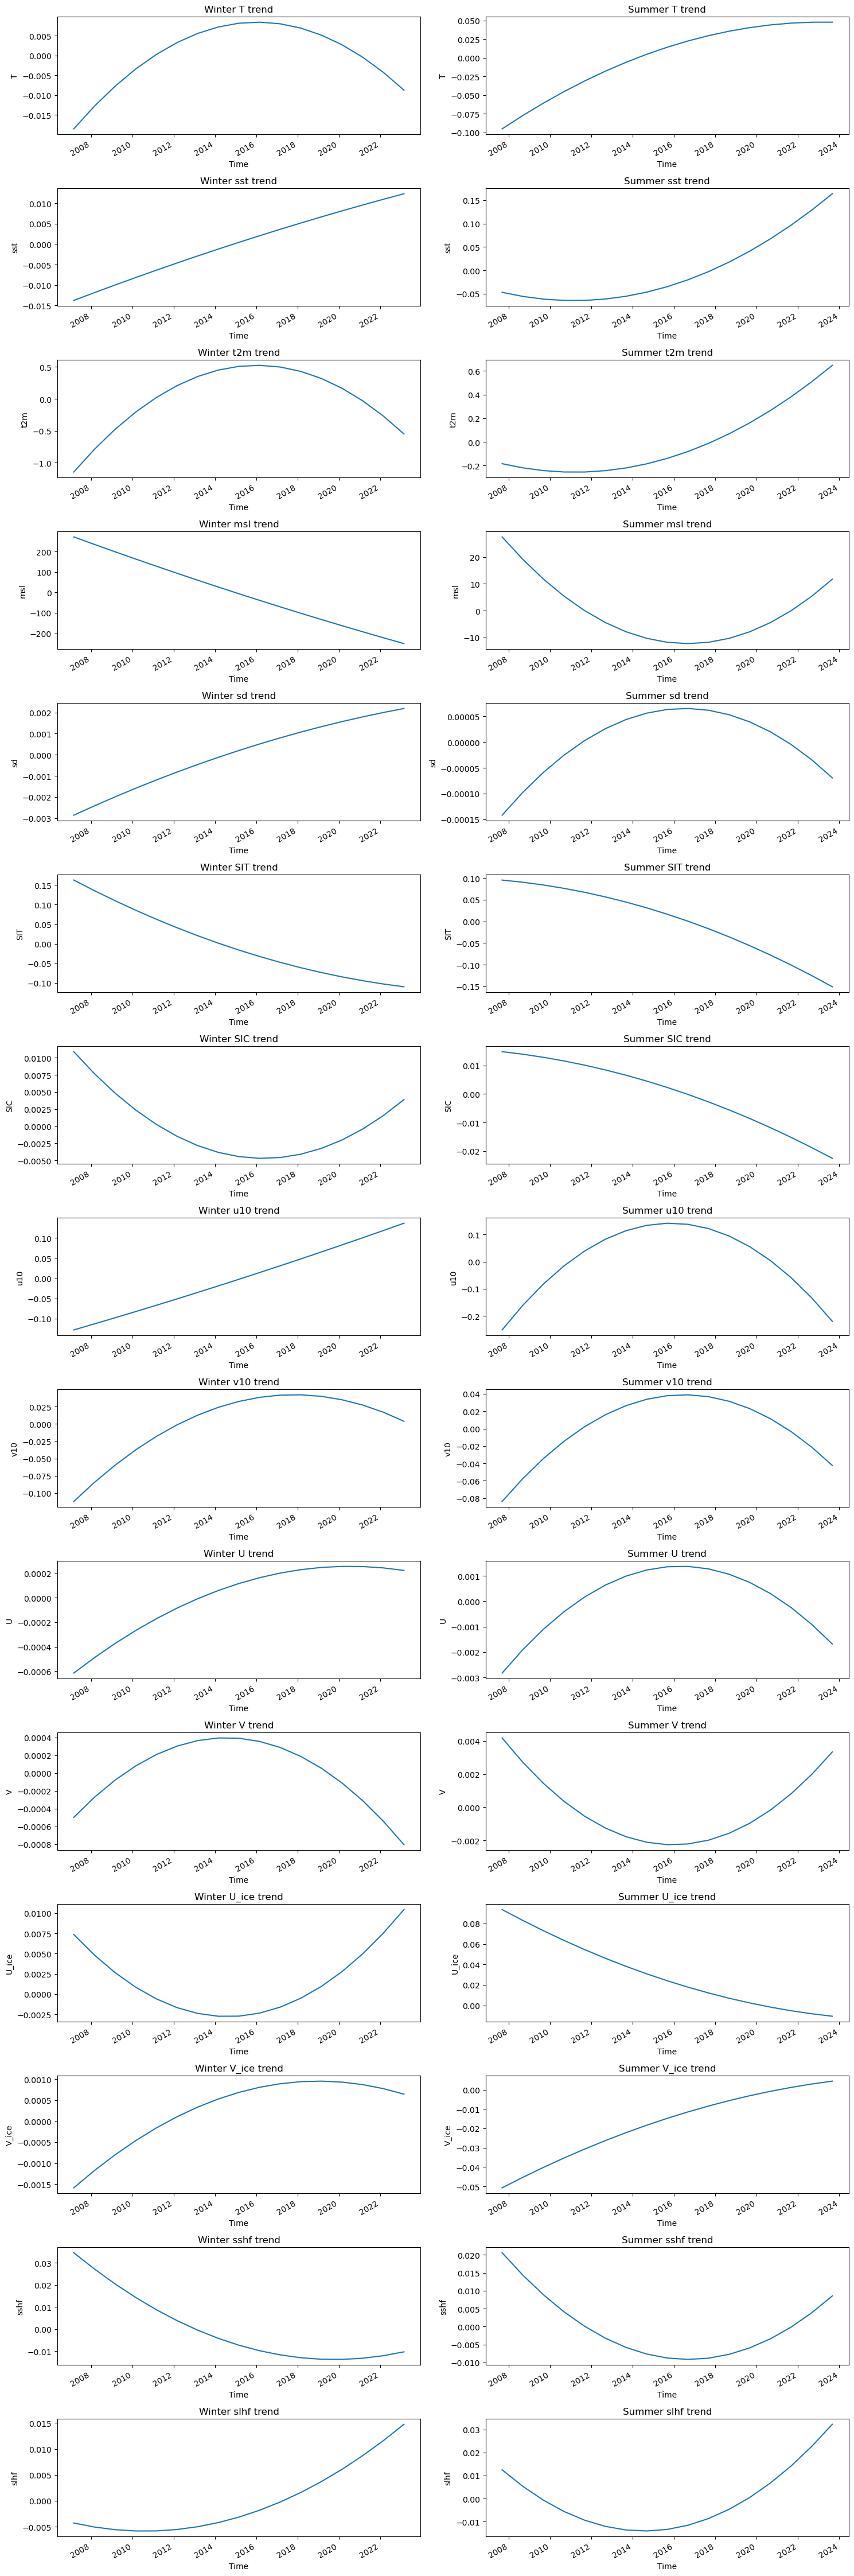

In [74]:
fig, axs = plt.subplots(len(ds_winter_trends.data_vars), 2, figsize=(15, 3*len(ds_winter_trends.data_vars)))

for i, var in enumerate(ds_winter_trends.data_vars):
    ds_winter_trends[var].mean(['latitude', 'longitude']).plot(ax=axs[i, 0])
    ds_summer_trends[var].mean(['latitude', 'longitude']).plot(ax=axs[i, 1])
    axs[i, 0].set_title(f'Winter {var} trend')
    axs[i, 1].set_title(f'Summer {var} trend')

plt.tight_layout()
plt.show()


In [75]:
# Remove trends
ds_winter_anomalies_detrended = ds_winter_anomalies - ds_winter_trends
ds_summer_anomalies_detrended = ds_summer_anomalies - ds_summer_trends

for var in ds_winter_anomalies_detrended.data_vars:
    ds_winter_anomalies_detrended[var].attrs = ds_winter[var].attrs

for var in ds_summer_anomalies_detrended.data_vars:
    ds_summer_anomalies_detrended[var].attrs = ds_summer[var].attrs

# Variabiliy analysis

In [76]:
importlib.reload(utils_variability)

<module 'utils_variability' from '/Users/juliencollard/Nextcloud/Documents/Travail/Sorbonne/Cours/Code_MOCIS/PHO/PHO_Arctic/utils_variability.py'>

In [77]:
def get_U_V_plot(U,V,lat):
    ampl = np.sqrt(U**2 + V**2)
    V_corr = V * np.cos(np.deg2rad(lat))

    U_corr = U / np.sqrt(U**2 + V_corr**2) * ampl
    V_corr = V_corr / np.sqrt(U**2 + V_corr**2) * ampl

    return U_corr, V_corr

def centered_min_max(da):
    max_val = np.abs(da).max().values
    return -max_val, max_val

## Winter or summer

### SLP EOFs

In [93]:
# Computing EOFs
season = 'winter'

if season == 'winter':
    ds = ds_winter_anomalies_detrended
    ds_index = ds_winter_climate_index
    ds_climatology = ds_winter_climatology
else:
    ds = ds_summer_anomalies_detrended
    ds_index = ds_summer_climate_index
    ds_climatology = ds_summer_climatology

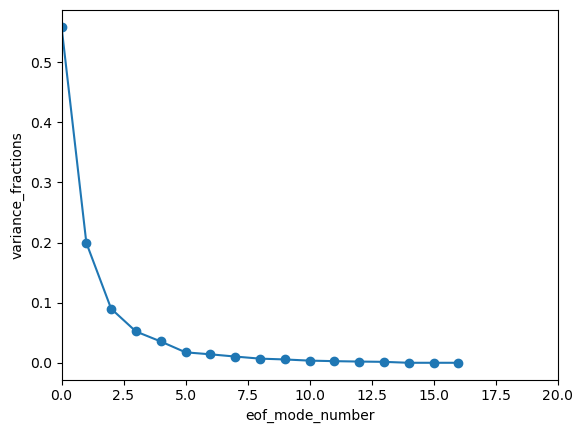

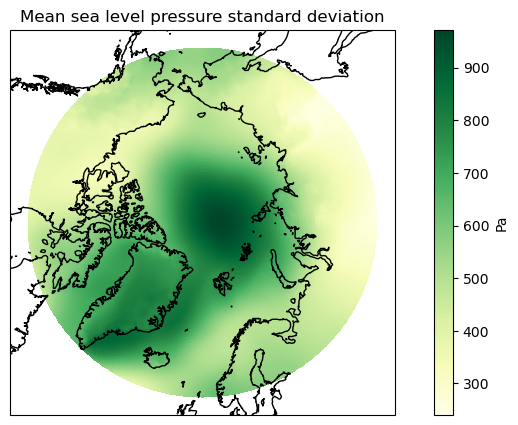

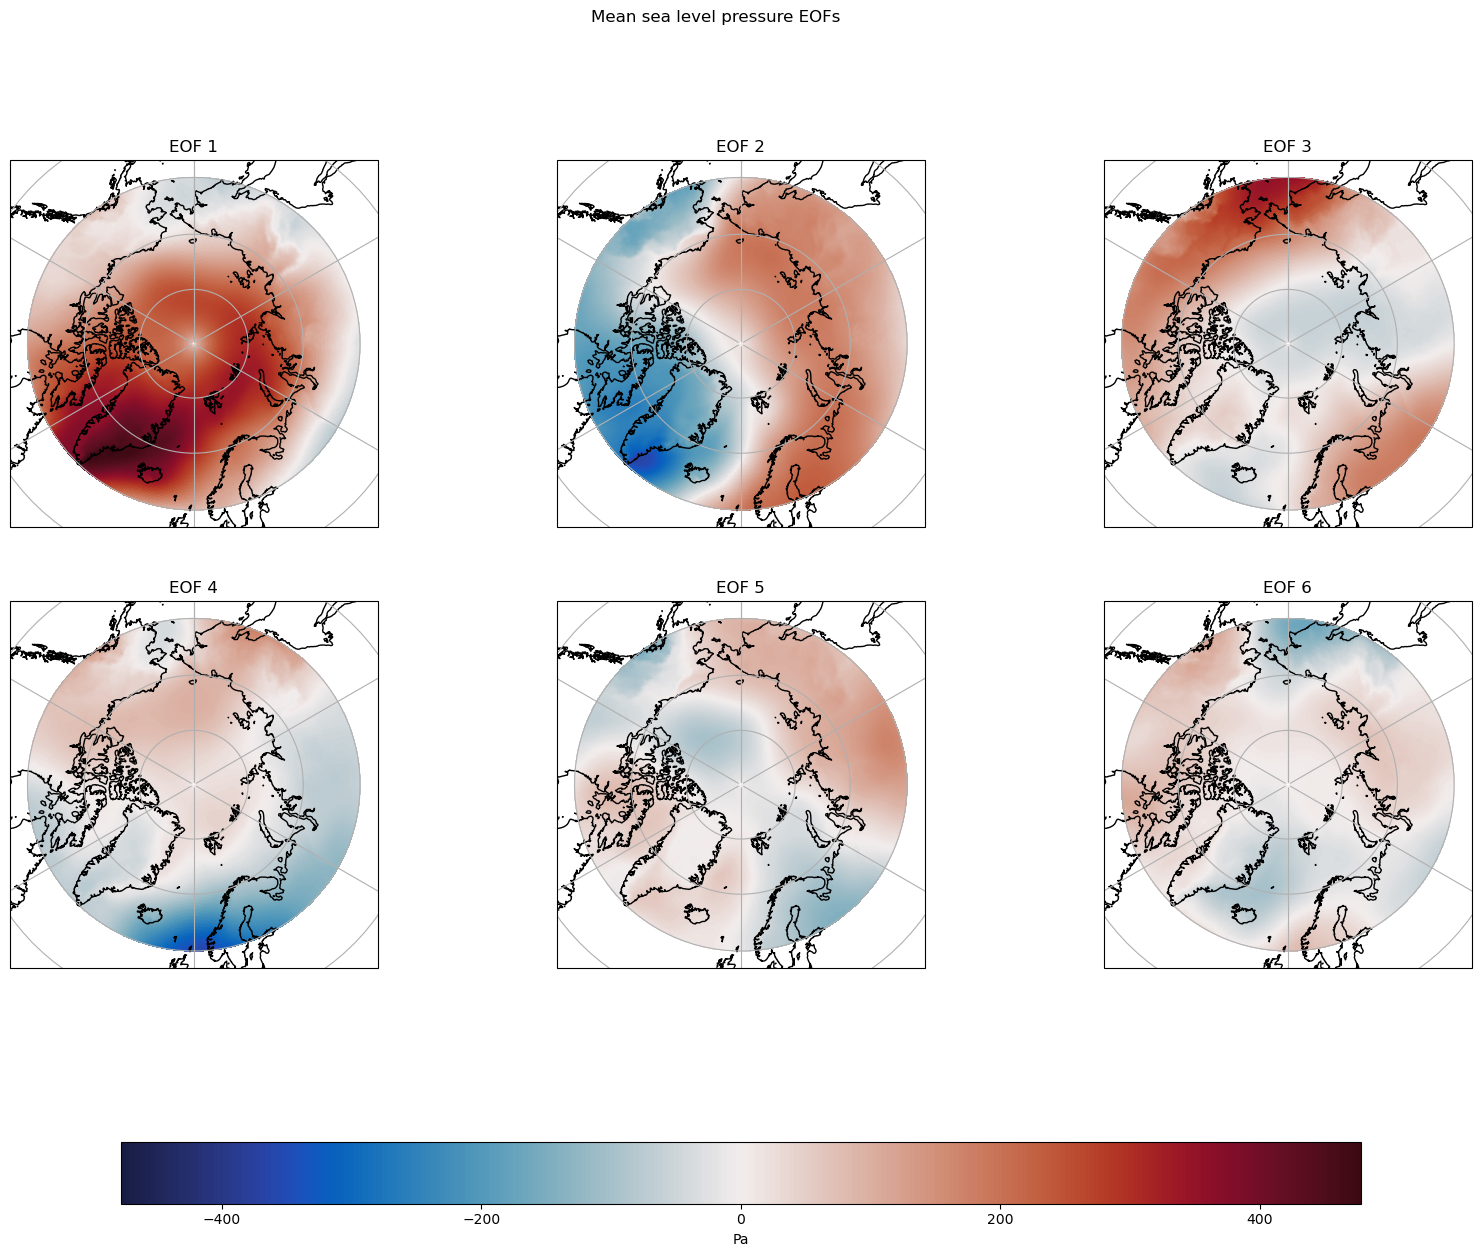

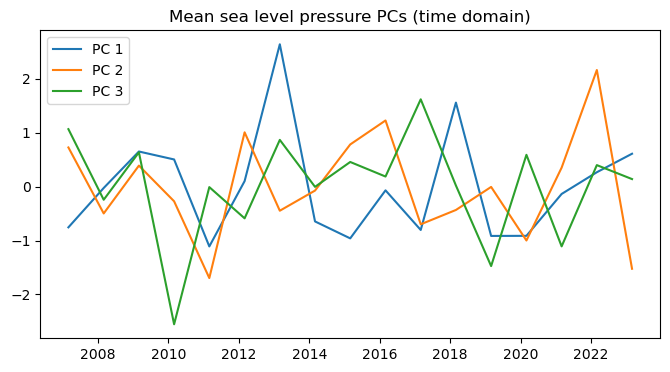

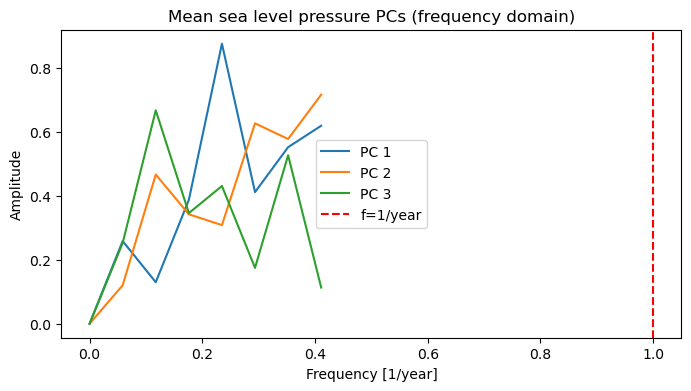

In [94]:

da = ds['msl']
msl_eof_solver = utils_variability.fit_eofs(da)
utils_variability.fast_eof_analysis(msl_eof_solver, da)

In [95]:
df = msl_eof_solver.varianceFraction().to_dataframe()
df.index = df.index + 1
df['variance_fractions'] *= 100
df = df.iloc[:5]
df.to_csv(f'figs/AO_variability/variance_fraction_{season}.csv')


#### AO ?

In [96]:
measured_AO = ds_index['AO']
pc1 = msl_eof_solver.pcs(1)[:,0]

corr = np.corrcoef(measured_AO, pc1)[0,1]
print(f'Correlation between measured and predicted AO: {corr}')

AO_time_serie_from_PC1 = pc1 * corr
AO_EOF_from_EOF1 = msl_eof_solver.eofs(eofscaling=2)[0] * corr

Correlation between measured and predicted AO: -0.9241135010927278


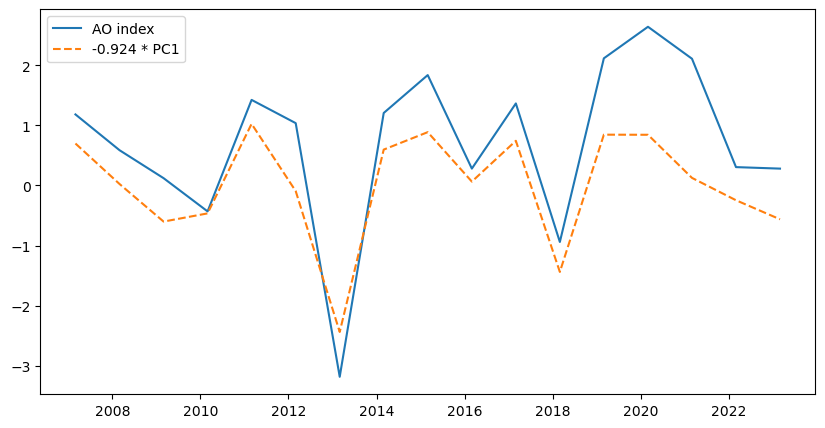

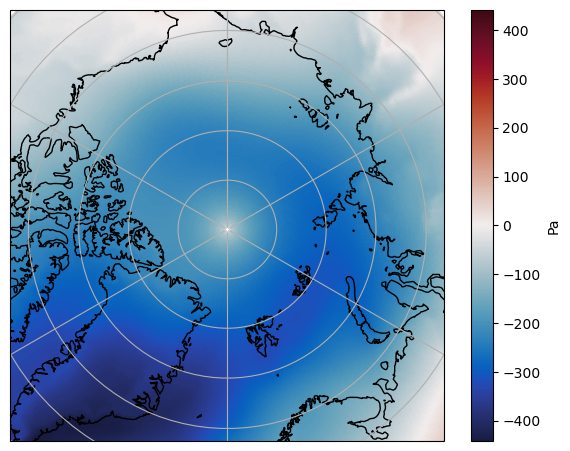

In [97]:
plt.figure(figsize=(10, 5))
plt.plot(ds_index.time,measured_AO, label='AO index')
plt.plot(msl_eof_solver.pcs(1).time, AO_time_serie_from_PC1, label=f'{corr:.3f} * PC1', linestyle='--')
plt.legend()
#plt.xlim(pd.DatetimeIndex(['2003-01-01', '2023-01-01']))
plt.savefig(f'figs/AO_variability/AO_time_serie_{season}.png', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax.set_extent([-180, 180, 68, 90], ccrs.PlateCarree())
vmin, mvax = centered_min_max(AO_EOF_from_EOF1)
ax.coastlines()
ax.gridlines()
pcm = ax.pcolormesh(
    AO_EOF_from_EOF1.longitude, 
    AO_EOF_from_EOF1.latitude, 
    AO_EOF_from_EOF1, 
    transform=ccrs.PlateCarree(), 
    cmap=cmo.balance,
    vmin=vmin,
    vmax=mvax
)
fig.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8, label=da.units)
plt.savefig(f'figs/AO_variability/AO_EOF_{season}.png', bbox_inches='tight')
plt.show()

### Regressions on AO EOF

In [98]:
projection = (ds * AO_time_serie_from_PC1).mean('time')
projection

<xarray.Dataset>
Dimensions:    (latitude: 121, longitude: 1440)
Coordinates:
  * latitude   (latitude) float32 60.0 60.25 60.5 60.75 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
    depth      float32 0.5058
    mode       int64 0
Data variables: (12/15)
    T          (latitude, longitude) float64 0.3461 0.3964 ... -0.00011 -0.00011
    sst        (latitude, longitude) float64 0.3345 0.347 ... -1.775e-05
    t2m        (latitude, longitude) float64 0.6681 0.6781 ... 0.3159 0.3159
    msl        (latitude, longitude) float64 55.0 54.14 53.24 ... -774.6 -774.6
    sd         (latitude, longitude) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SIT        (latitude, longitude) float64 -0.008086 -0.01145 ... 0.02069
    ...         ...
    U          (latitude, longitude) float64 0.006441 0.005685 ... 0.0002106
    V          (latitude, longitude) float64 0.003164 0.004719 ... 5.062e-06
    U_ice      (latitude, longitude) float64 nan nan nan nan ... nan nan nan nan
    V_ice      (latitude, longitude) float64 nan nan nan nan ... nan nan nan nan
    sshf       (latitude, longitude) float64 -0.352 -0.3487 ... 0.03214 0.03214
    slhf       (latitude, longitude) float64 -0.1042 -0.09669 ... 0.003139

In [99]:
longitude_mg ,latitude_mg = np.meshgrid(projection.longitude, projection.latitude)

sea_mask = ~ projection['sst'].isnull()

##### Atmospheric climate

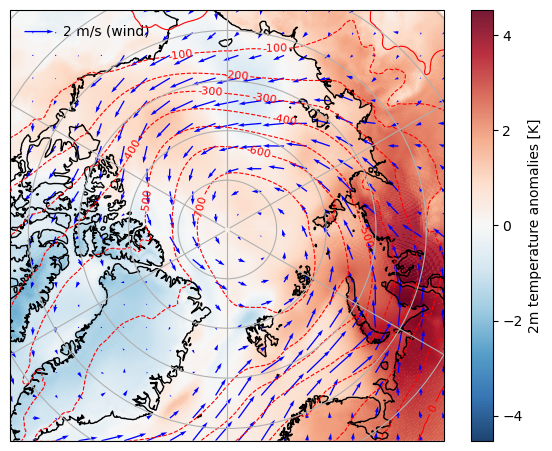

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})
max_val = np.abs(projection['t2m']).max()
ax.set_extent([-180, 180, 68, 90], ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()


vmin, vmax = centered_min_max(projection['t2m'])
pcm = ax.pcolormesh(
    projection.longitude, 
    projection.latitude, 
    projection['t2m'], 
    transform=ccrs.PlateCarree(), 
    cmap='RdBu_r',
    alpha=.9,
    vmin=vmin,
    vmax=vmax

)

u10_plot, v10_plot = get_U_V_plot(projection['u10'], projection['v10'], projection.latitude)
qvr = ax.quiver(
    longitude_mg, 
    latitude_mg, 
    u10_plot.values, 
    v10_plot.values, 
    transform=ccrs.PlateCarree(),
    regrid_shape=20,
    scale=30,
    color='blue'
)
ax.quiverkey(qvr, 0.1, 0.95, 2, '2 m/s (wind)', labelpos='E')

cntr = ax.contour(
    projection.longitude, 
    projection.latitude, 
    projection['msl'], 
    transform=ccrs.PlateCarree(), 
    colors='red',
    linewidths=.8,
    levels=8
)
ax.clabel(cntr, inline=True, fontsize=8, fmt='%1.0f')
#ax.set_title(f'Atmospheric positive AO mode')
fig.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8, label='2m temperature anomalies [K]')
plt.savefig(f'figs/AO_variability/atm_{season}.png', bbox_inches='tight')
plt.show()


##### Ocean climate

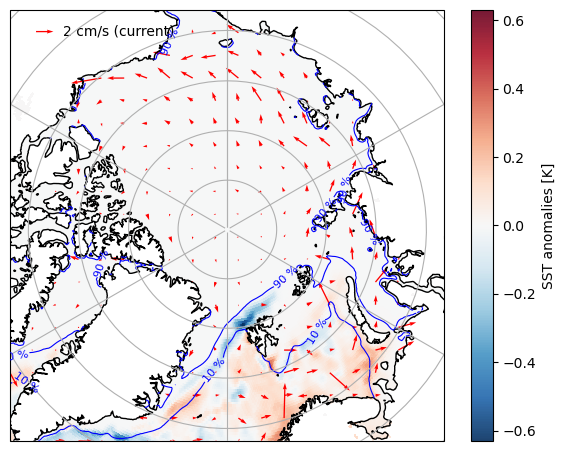

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})
max_val = np.abs(projection['sst']).max()
ax.set_extent([-180, 180, 68, 90], ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
vmin, vmax = centered_min_max(projection['sst'])
pcm = ax.pcolormesh(
    projection.longitude, 
    projection.latitude, 
    projection['sst'], 
    transform=ccrs.PlateCarree(), 
    cmap='RdBu_r',
    alpha=.9,
    vmin=vmin,
    vmax=vmax
)

U_plot, V_plot = get_U_V_plot(projection['U'], projection['V'], projection.latitude)
qvr = ax.quiver(
    longitude_mg, 
    latitude_mg, 
    U_plot.values, 
    V_plot.values, 
    transform=ccrs.PlateCarree(),
    regrid_shape=20,
    scale=0.5,
    color='red'
)
ax.quiverkey(qvr, 0.1, 0.95, 0.02, '2 cm/s (current)', labelpos='E')

cntr = ax.contour(
    ds_climatology.longitude, 
    ds_climatology.latitude, 
    ds_climatology['SIC'] * 100, 
    transform=ccrs.PlateCarree(), 
    colors='blue',
    linewidths=.8,
    levels=[10, 90]
)
ax.clabel(cntr, inline=True, fontsize=8, fmt='%1.0f %%')


fig.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8, label='SST anomalies [K]')
plt.savefig(f'figs/AO_variability/ocean_{season}.png', bbox_inches='tight')
plt.show()


climato check

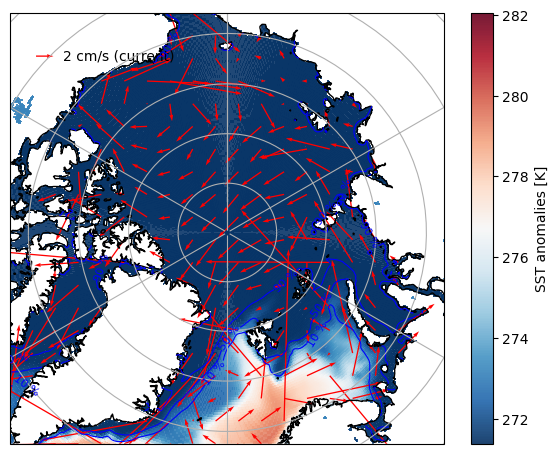

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})
max_val = np.abs(projection['sst']).max()
ax.set_extent([-180, 180, 68, 90], ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()

pcm = ax.pcolormesh(
    ds_climatology.longitude, 
    ds_climatology.latitude, 
    ds_climatology['sst'], 
    transform=ccrs.PlateCarree(), 
    cmap='RdBu_r',
    alpha=.9
)

U_plot, V_plot = get_U_V_plot(ds_climatology['U'], ds_climatology['V'], projection.latitude)
qvr = ax.quiver(
    longitude_mg, 
    latitude_mg, 
    U_plot.values, 
    V_plot.values, 
    transform=ccrs.PlateCarree(),
    regrid_shape=20,
    scale=0.5,
    color='red'
)
ax.quiverkey(qvr, 0.1, 0.9, 0.02, '2 cm/s (current)', labelpos='E')

cntr = ax.contour(
    ds_climatology.longitude, 
    ds_climatology.latitude, 
    ds_climatology['SIC'] * 100, 
    transform=ccrs.PlateCarree(), 
    colors='blue',
    linewidths=.8,
    levels=[10, 50, 90]
)
ax.clabel(cntr, inline=True, fontsize=8, fmt='%1.0f %%')


fig.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8, label='SST anomalies [K]')
plt.show()


##### Ice

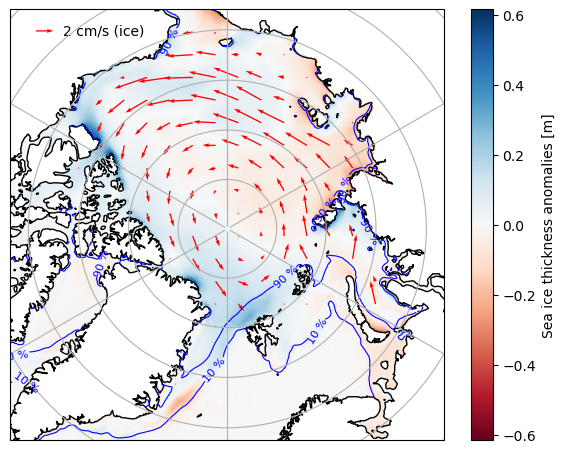

In [103]:

fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})
max_val = np.abs(projection['SIT']).max()
ax.set_extent([-180, 180, 68, 90], ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()

vmin, vmax = centered_min_max(projection['SIT'])
pcm = ax.pcolormesh(
    projection.longitude, 
    projection.latitude, 
    projection['SIT'], 
    transform=ccrs.PlateCarree(), 
    cmap='RdBu',
    vmin = vmin,
    vmax = vmax
)


U_ice_plot, V_ice_plot = get_U_V_plot(projection['U_ice'], projection['V_ice'], projection.latitude)
qvr = ax.quiver(
    longitude_mg, 
    latitude_mg, 
    U_ice_plot.values, 
    V_ice_plot.values, 
    transform=ccrs.PlateCarree(),
    regrid_shape=20,
    scale=0.5,
    color='red'
)
ax.quiverkey(qvr, 0.1, 0.95, 0.02, '2 cm/s (ice)', labelpos='E')

cntr = ax.contour(
    ds_climatology.longitude, 
    ds_climatology.latitude, 
    ds_climatology['SIC'] * 100, 
    transform=ccrs.PlateCarree(), 
    colors='blue',
    linewidths=.8,
    levels=[10, 90]
)
ax.clabel(cntr, inline=True, fontsize=8, fmt='%1.0f %%')


fig.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8, label='Sea ice thickness anomalies [m]')
plt.savefig(f'figs/AO_variability/ice_{season}.png', bbox_inches='tight')
plt.show()


Climato check

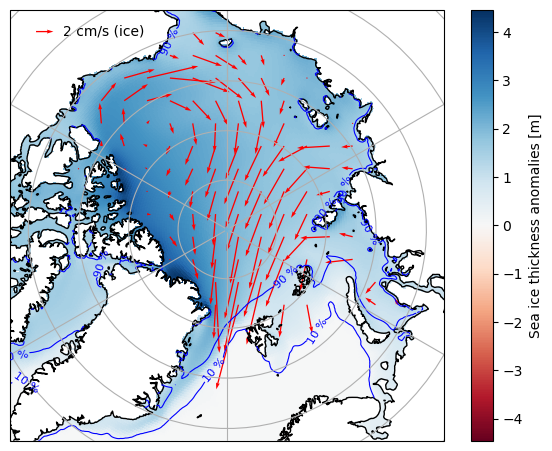

In [104]:

fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})
max_val = np.abs(projection['SIT']).max()
ax.set_extent([-180, 180, 68, 90], ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
pcm = ax.pcolormesh(
    projection.longitude, 
    projection.latitude, 
    ds_climatology['SIT'], 
    transform=ccrs.PlateCarree(), 
    cmap='RdBu',
    norm=colors.CenteredNorm()
)

U_ice_plot, V_ice_plot = get_U_V_plot(ds_climatology['U_ice'], ds_climatology['V_ice'], projection.latitude)
qvr = ax.quiver(
    longitude_mg, 
    latitude_mg, 
    U_ice_plot.values, 
    V_ice_plot.values, 
    transform=ccrs.PlateCarree(),
    regrid_shape=20,
    scale=0.5,
    color='red'
)
ax.quiverkey(qvr, 0.1, 0.95, 0.02, '2 cm/s (ice)', labelpos='E')

cntr = ax.contour(
    ds_climatology.longitude, 
    ds_climatology.latitude, 
    ds_climatology['SIC'] * 100, 
    transform=ccrs.PlateCarree(), 
    colors='blue',
    linewidths=.8,
    levels=[10, 90]
)
ax.clabel(cntr, inline=True, fontsize=8, fmt='%1.0f %%')


fig.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8, label='Sea ice thickness anomalies [m]')
plt.show()


##### Flux

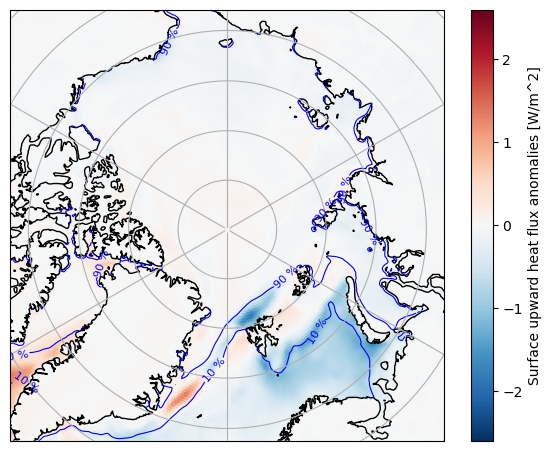

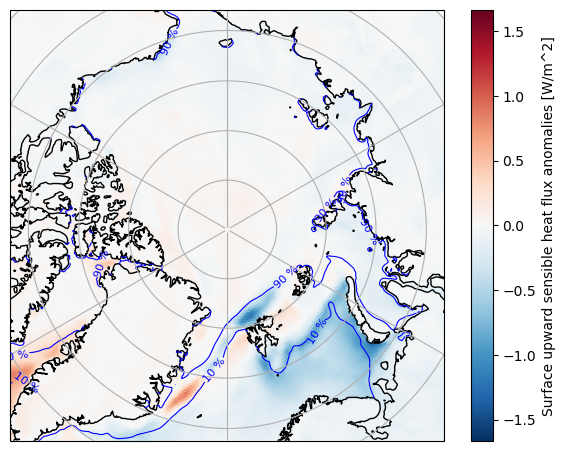

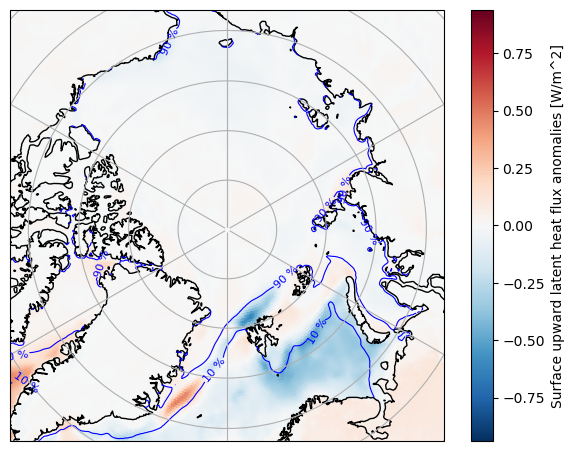

In [105]:

fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})
max_val = np.abs(projection['SIT']).max()
ax.set_extent([-180, 180, 68, 90], ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()

flux = projection['sshf'] + projection['slhf']

vmin, vmax = centered_min_max(flux)
pcm = ax.pcolormesh(
    projection.longitude, 
    projection.latitude, 
    flux, 
    transform=ccrs.PlateCarree(), 
    cmap='RdBu_r',
    vmin = vmin,
    vmax = vmax
)

cntr = ax.contour(
    ds_climatology.longitude, 
    ds_climatology.latitude, 
    ds_climatology['SIC'] * 100, 
    transform=ccrs.PlateCarree(), 
    colors='blue',
    linewidths=.8,
    levels=[10, 90]
)
ax.clabel(cntr, inline=True, fontsize=8, fmt='%1.0f %%')


fig.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8, label='Surface upward heat flux anomalies [W/m^2]')
plt.savefig(f'figs/AO_variability/up_flux_{season}.png', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})
max_val = np.abs(projection['SIT']).max()
ax.set_extent([-180, 180, 68, 90], ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()

flux = projection['sshf']

vmin, vmax = centered_min_max(flux)
pcm = ax.pcolormesh(
    projection.longitude, 
    projection.latitude, 
    flux, 
    transform=ccrs.PlateCarree(), 
    cmap='RdBu_r',
    vmin = vmin,
    vmax = vmax
)

cntr = ax.contour(
    ds_climatology.longitude, 
    ds_climatology.latitude, 
    ds_climatology['SIC'] * 100, 
    transform=ccrs.PlateCarree(), 
    colors='blue',
    linewidths=.8,
    levels=[10, 90]
)
ax.clabel(cntr, inline=True, fontsize=8, fmt='%1.0f %%')


fig.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8, label='Surface upward sensible heat flux anomalies [W/m^2]')
plt.savefig(f'figs/AO_variability/up_sensible_flux_{season}.png', bbox_inches='tight')
plt.show()



fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})
max_val = np.abs(projection['SIT']).max()
ax.set_extent([-180, 180, 68, 90], ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()

flux = projection['slhf']

vmin, vmax = centered_min_max(flux)
pcm = ax.pcolormesh(
    projection.longitude, 
    projection.latitude, 
    flux, 
    transform=ccrs.PlateCarree(), 
    cmap='RdBu_r',
    vmin = vmin,
    vmax = vmax
)

cntr = ax.contour(
    ds_climatology.longitude, 
    ds_climatology.latitude, 
    ds_climatology['SIC'] * 100, 
    transform=ccrs.PlateCarree(), 
    colors='blue',
    linewidths=.8,
    levels=[10, 90]
)
ax.clabel(cntr, inline=True, fontsize=8, fmt='%1.0f %%')


fig.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8, label='Surface upward latent heat flux anomalies [W/m^2]')
plt.savefig(f'figs/AO_variability/up_latent_flux_{season}.png', bbox_inches='tight')
plt.show()

climato check

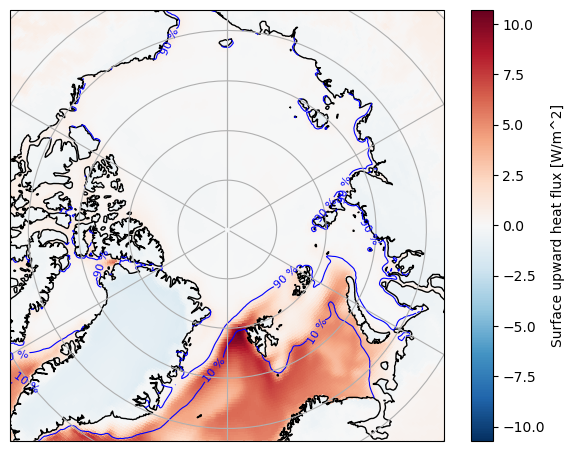

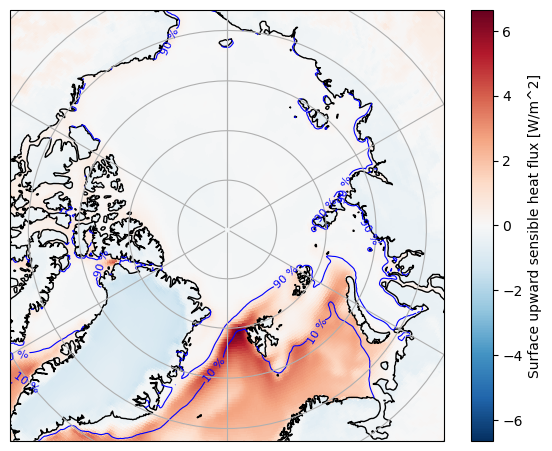

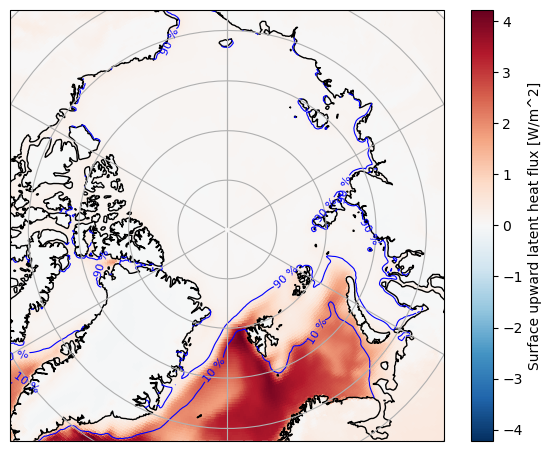

In [106]:

fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})
max_val = np.abs(projection['SIT']).max()
ax.set_extent([-180, 180, 68, 90], ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()

flux = ds_climatology['sshf'] + ds_climatology['slhf']

vmin, vmax = centered_min_max(flux)
pcm = ax.pcolormesh(
    ds_climatology.longitude, 
    ds_climatology.latitude, 
    flux, 
    transform=ccrs.PlateCarree(), 
    cmap='RdBu_r',
    vmin = vmin,
    vmax = vmax
)

cntr = ax.contour(
    ds_climatology.longitude, 
    ds_climatology.latitude, 
    ds_climatology['SIC'] * 100, 
    transform=ccrs.PlateCarree(), 
    colors='blue',
    linewidths=.8,
    levels=[10, 90]
)
ax.clabel(cntr, inline=True, fontsize=8, fmt='%1.0f %%')


fig.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8, label='Surface upward heat flux [W/m^2]')
plt.savefig(f'figs/AO_variability/up_flux_{season}_climatology.png', bbox_inches='tight')
plt.show()




fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})
max_val = np.abs(projection['SIT']).max()
ax.set_extent([-180, 180, 68, 90], ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()

flux = ds_climatology['sshf']

vmin, vmax = centered_min_max(flux)
pcm = ax.pcolormesh(
    ds_climatology.longitude, 
    ds_climatology.latitude, 
    flux, 
    transform=ccrs.PlateCarree(), 
    cmap='RdBu_r',
    vmin = vmin,
    vmax = vmax
)

cntr = ax.contour(
    ds_climatology.longitude, 
    ds_climatology.latitude, 
    ds_climatology['SIC'] * 100, 
    transform=ccrs.PlateCarree(), 
    colors='blue',
    linewidths=.8,
    levels=[10, 90]
)
ax.clabel(cntr, inline=True, fontsize=8, fmt='%1.0f %%')


fig.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8, label='Surface upward sensible heat flux [W/m^2]')
plt.savefig(f'figs/AO_variability/up_sensible_flux_{season}_climatology.png', bbox_inches='tight')
plt.show()



fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})
max_val = np.abs(projection['SIT']).max()
ax.set_extent([-180, 180, 68, 90], ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()

flux = ds_climatology['slhf']

vmin, vmax = centered_min_max(flux)
pcm = ax.pcolormesh(
    ds_climatology.longitude, 
    ds_climatology.latitude, 
    flux, 
    transform=ccrs.PlateCarree(), 
    cmap='RdBu_r',
    vmin = vmin,
    vmax = vmax
)

cntr = ax.contour(
    ds_climatology.longitude, 
    ds_climatology.latitude, 
    ds_climatology['SIC'] * 100, 
    transform=ccrs.PlateCarree(), 
    colors='blue',
    linewidths=.8,
    levels=[10, 90]
)
ax.clabel(cntr, inline=True, fontsize=8, fmt='%1.0f %%')


fig.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8, label='Surface upward latent heat flux [W/m^2]')
plt.savefig(f'figs/AO_variability/up_latent_flux_{season}_climatology.png', bbox_inches='tight')
plt.show()

Significativity

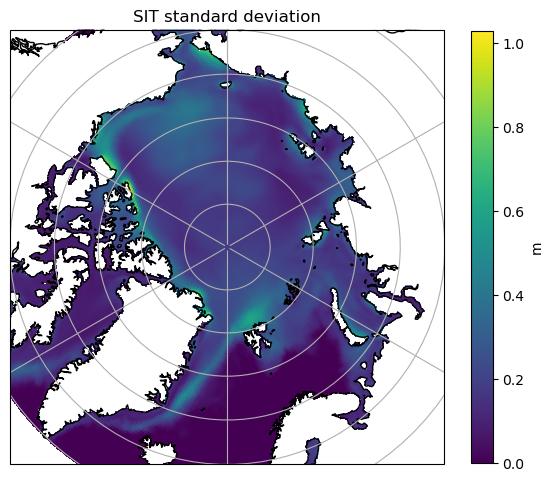

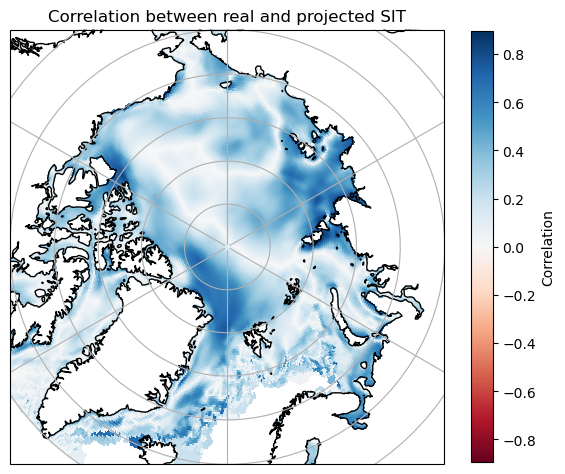

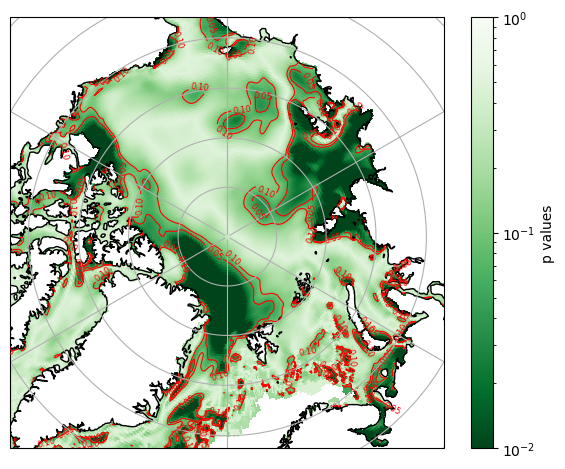

In [107]:

real_SIT = ds['SIT'] # (time, latitude, longitude)
projected_SIT = projection['SIT'] * AO_time_serie_from_PC1 # (time, latitude, longitude)
corr = (real_SIT * projected_SIT).sum('time') / (real_SIT.std('time') * projected_SIT.std('time')) / len(real_SIT.time)

t_test = corr * np.sqrt(len(real_SIT.time) - 2) / np.sqrt(1 - corr**2)

# Compute p-values from t-test
p_values = 1 - scipy.stats.t.cdf(np.abs(t_test), df=len(real_SIT.time) - 2)

fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})
max_val = np.abs(corr).max()
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
pcm = ax.pcolormesh(
    corr.longitude, 
    corr.latitude, 
    real_SIT.std('time'), 
    transform=ccrs.PlateCarree(), 
    cmap='viridis'
)
ax.set_title(f'SIT standard deviation')
fig.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8, label='m')


fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})
max_val = np.abs(corr).max()
ax.set_extent([-180, 180, 65, 90], ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
pcm = ax.pcolormesh(
    corr.longitude, 
    corr.latitude, 
    corr, 
    transform=ccrs.PlateCarree(), 
    cmap='RdBu',
    vmin=-max_val,
    vmax=max_val,
)
ax.set_title(f'Correlation between real and projected SIT')
fig.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8, label='Correlation')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(7, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})
ax.set_extent([-180, 180, 68, 90], ccrs.PlateCarree())
max_val = np.abs(corr).max()
ax.coastlines()
ax.gridlines()
pcm = ax.pcolormesh(
    corr.longitude, 
    corr.latitude, 
    p_values, 
    transform=ccrs.PlateCarree(), 
    cmap='Greens_r',
    norm=colors.LogNorm(vmin=1e-2, vmax=1),
)
cntr = ax.contour(
    corr.longitude, 
    corr.latitude, 
    p_values, 
    transform=ccrs.PlateCarree(), 
    levels=[0.05, 0.1],
    colors='red',
    linewidths=0.8
)
ax.clabel(cntr, inline=True, fontsize=6, fmt='%1.2f')

fig.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8, label='p values')
plt.savefig(f'figs/AO_variability/SIT_p_values_{season}.png', bbox_inches='tight')
plt.show()
